In [1]:
from dataset.dataloader import get_data_loaders
from model.train_model import train_model
from model.model import PoetClassifier
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
train_loader, val_loader, test_loader = get_data_loaders("dataset/kaggle_poem_dataset.csv")

In [3]:
trained_model = train_model(PoetClassifier(), train_loader, val_loader)
print("done training")

Epoch 1/10 - Loss: 7.2803, Validation Accuracy: 0.0035
Epoch 2/10 - Loss: 6.9869, Validation Accuracy: 0.0074
Epoch 3/10 - Loss: 6.8109, Validation Accuracy: 0.0074
Epoch 4/10 - Loss: 6.7824, Validation Accuracy: 0.0074
Epoch 5/10 - Loss: 6.7699, Validation Accuracy: 0.0074
Epoch 6/10 - Loss: 6.7594, Validation Accuracy: 0.0083
Epoch 7/10 - Loss: 6.7589, Validation Accuracy: 0.0074
Epoch 8/10 - Loss: 6.7522, Validation Accuracy: 0.0044
Epoch 9/10 - Loss: 6.7554, Validation Accuracy: 0.0074
Epoch 10/10 - Loss: 6.7490, Validation Accuracy: 0.0074
done training


In [4]:
def evaluate_model(model, train_loader, test_loader, 
                   device=torch.device("cuda" if torch.cuda.is_available() else "cpu")):
    model.eval()  # Set model to evaluation mode

    def evaluate(loader):
        total_loss = 0.0
        all_labels, all_preds = [], []
        
        with torch.no_grad():
            for poems, attention_mask, labels in loader:
                poems, attention_mask, labels = (
                    poems.to(device),
                    attention_mask.to(device),
                    labels.to(device)
                )
                
                outputs = model(poems, attention_mask)
                loss = F.cross_entropy(outputs, labels)
                total_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())

        avg_loss = total_loss / len(loader)
        accuracy = accuracy_score(all_labels, all_preds)
        f1 = f1_score(all_labels, all_preds, average='weighted')
        
        return avg_loss, accuracy, f1

    # Get evaluation metrics
    train_loss, train_acc, train_f1 = evaluate(train_loader)
    test_loss, test_acc, test_f1 = evaluate(test_loader)

    # Plot metrics
    metrics = ['Loss', 'Accuracy', 'F1 Score']
    train_metrics = [train_loss, train_acc, train_f1]
    test_metrics = [test_loss, test_acc, test_f1]

    plt.figure(figsize=(12, 4))

    for i, metric in enumerate(metrics):
        plt.subplot(1, 3, i + 1)
        plt.bar(['Train', 'Test'], [train_metrics[i], test_metrics[i]], color=['blue', 'orange'])
        plt.title(f'{metric} Comparison')
        plt.ylabel(metric)

    plt.tight_layout()
    plt.show()

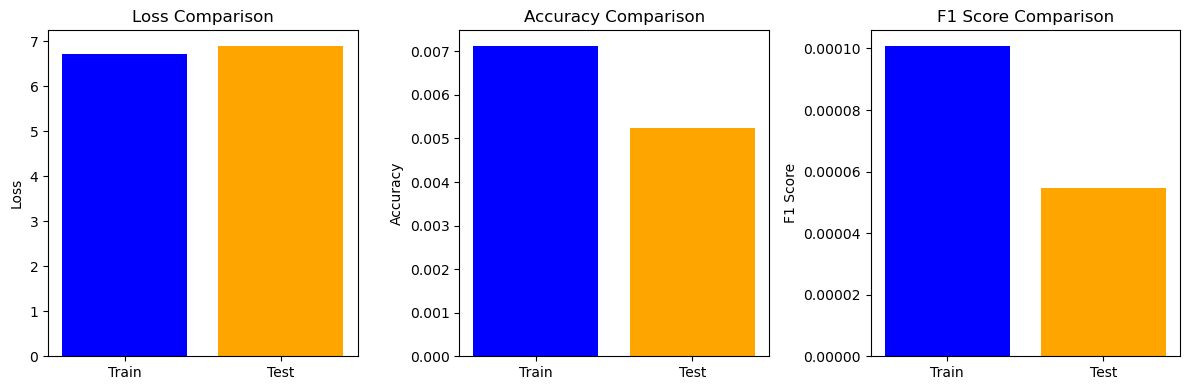

In [5]:
evaluate_model(trained_model, train_loader, test_loader)